Predicting winners using moves feature/column using LSTM

In [1]:
#Importing all the libraries
import numpy as np
import pandas as pd 
from keras.models import Model,Sequential
from keras.layers import Dense
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Input, Dropout, LSTM, Activation
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence,text
from matplotlib import pyplot


In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
#Reading the dataset
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/SCG_Task_Srini/games.csv')
df.head(5)

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply
0,TZJHLljE,False,1.504210e+12,1.504210e+12,13,outoftime,white,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5
1,l1NXvwaE,True,1.504130e+12,1.504130e+12,16,resign,black,5+10,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4
2,mIICvQHh,True,1.504130e+12,1.504130e+12,61,mate,white,5+10,ischia,1496,a-00,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3
3,kWKvrqYL,True,1.504110e+12,1.504110e+12,61,mate,white,20+0,daniamurashov,1439,adivanov2009,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,Queen's Pawn Game: Zukertort Variation,3
4,9tXo1AUZ,True,1.504030e+12,1.504030e+12,95,mate,white,30+3,nik221107,1523,adivanov2009,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,Philidor Defense,5


In [4]:
df.shape

(20058, 16)

In [5]:
df.columns

Index(['id', 'rated', 'created_at', 'last_move_at', 'turns', 'victory_status',
       'winner', 'increment_code', 'white_id', 'white_rating', 'black_id',
       'black_rating', 'moves', 'opening_eco', 'opening_name', 'opening_ply'],
      dtype='object')

Preprocessing

In [6]:
df['winner'].unique()

array(['white', 'black', 'draw'], dtype=object)

In [7]:
#Deleting the rows where the winner is draw or including the rows where the winner is white or black
df.query("winner != 'draw'")
df.head()

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply
0,TZJHLljE,False,1.504210e+12,1.504210e+12,13,outoftime,white,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5
1,l1NXvwaE,True,1.504130e+12,1.504130e+12,16,resign,black,5+10,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4
2,mIICvQHh,True,1.504130e+12,1.504130e+12,61,mate,white,5+10,ischia,1496,a-00,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3
3,kWKvrqYL,True,1.504110e+12,1.504110e+12,61,mate,white,20+0,daniamurashov,1439,adivanov2009,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,Queen's Pawn Game: Zukertort Variation,3
4,9tXo1AUZ,True,1.504030e+12,1.504030e+12,95,mate,white,30+3,nik221107,1523,adivanov2009,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,Philidor Defense,5


In [8]:
#extracting all the moves as an array
moves = np.array(df.query("winner != 'draw'")['moves'])
moves

array(['d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5 Bf4',
       'd4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6 Qe5+ Nxe5 c4 Bb4+',
       'e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc6 bxc6 Ra6 Nc4 a4 c3 a3 Nxa3 Rxa3 Rxa3 c4 dxc4 d5 cxd5 Qxd5 exd5 Be6 Ra8+ Ke7 Bc5+ Kf6 Bxf8 Kg6 Bxg7 Kxg7 dxe6 Kh6 exf7 Nf6 Rxh8 Nh5 Bxh5 Kg5 Rxh7 Kf5 Qf3+ Ke6 Bg4+ Kd6 Rh6+ Kc5 Qe3+ Kb5 c4+ Kb4 Qc3+ Ka4 Bd1#',
       ...,
       'd4 d5 Bf4 Nc6 e3 Nf6 c3 e6 Nf3 Be7 Bd3 O-O Nbd2 b6 Ne5 Nxe5 Bxe5 Nd7 Bxh7+ Kxh7 Qh5+ Kg8 Nf3 f6 Bf4 g5 Qg6+ Kh8 Nh4 Qe8 Qh6+ Kg8 Ng6 Kf7 Qh7#',
       'e4 d6 d4 Nf6 e5 dxe5 dxe5 Qxd1+ Kxd1 Nd5 c4 Nb6 c5 Nd5 Bc4 e6 Bxd5 exd5 Nc3 d4 Ne4 Bf5 f3 Nd7 b4 Nxe5 Bf4 f6 g4 Bxe4 fxe4 c6 Bxe5 fxe5 Nf3 Be7 Nxe5 Bf6 Nc4 O-O-O h4 h6 e5 b5 cxb6 Be7 bxa7 Kc7 a3 Rhf8 Kd2 Rf4 Rag1 d3 h5 Rf2+ Ke3 Re2+ Kf4 Rf8+ Kg3 Re3+ Nxe3 d2 Rd1 Bg5 Nf5 Kb7 Rhf1 Kxa7 Nd6 Rxf1 Rxf1 Kb6 e6 Kc7 Nf5 Kc8 e7 Kd7 a4 Bxe7 Nxe7 Kxe7 a5 Kd7 Rd1 Kc7 Rxd2 Kb7 Ra2 Ka6 Kf4 Kb5 a6 Kb6 a7 Kb5 a8=Q Kxb4 Qxc6 g5+ hxg6 Kb3 Rc

In [9]:
#Converting winner labels to 1 0r 0
labels = np.array(df.query("winner != 'draw'")['winner'].apply(lambda x : 1 if x == 'white' else 0))
labels

array([1, 0, 1, ..., 1, 1, 0])

In [10]:
#Shape of the moves feature 
moves.shape

(19108,)

In [11]:
#Shape of the Labels
labels.shape

(19108,)

In [12]:
# Finding all the unique moves
all_moves = set()

for move_list in moves:
    for move in move_list.split(" "):
        if move not in all_moves:
            all_moves.add(move)



In [13]:
#length of all moves
max_vocab = len(all_moves)
max_vocab

4373

In [14]:
# Finding the length of longest sequence of moves
max_len = 0
for move_list in moves:
    if len(move_list.split(" ")) > max_len:
        max_len = len(move_list.split(" "))
        
print("Max length : " + str(max_len))

Max length : 349


In [15]:
print(max_vocab)
print(max_len)

4373
349


In [16]:
tokenizer = Tokenizer(num_words = max_vocab)
tokenizer.fit_on_texts(moves) #creates the vocabulary index based on word frequency
sequences = tokenizer.texts_to_sequences(moves)#Transforms each text in texts to a sequence of integers
word_index = tokenizer.word_index



In [17]:
model_inputs = pad_sequences(sequences, maxlen = max_len)
model_inputs

array([[  0,   0,   0, ...,   9, 363,  58],
       [  0,   0,   0, ...,  41,  11,  60],
       [  0,   0,   0, ..., 202, 521, 563],
       ...,
       [  0,   0,   0, ..., 194,  86, 528],
       [  0,   0,   0, ..., 360, 505,  85],
       [  0,   0,   0, ..., 247, 177, 280]], dtype=int32)

In [18]:
model_inputs.shape

(19108, 349)

In [19]:
labels.shape

(19108,)

In [20]:
#split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(model_inputs, labels, train_size = 0.8, random_state = 24)

In [23]:
#Building an LSTM
embedding_dim=512
model=Sequential()
model.add(Embedding(max_vocab, embedding_dim, input_length=max_len))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 349, 512)          2238976   
                                                                 
 lstm_1 (LSTM)               (None, 100)               245200    
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 2,484,277
Trainable params: 2,484,277
Non-trainable params: 0
_________________________________________________________________
None


In [25]:
# Model compilation
model.compile(loss='binary_crossentropy', 
             optimizer='adam', 
             metrics=['accuracy'])

In [26]:
#Fitting the model to the train data
hist = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32  ,epochs=5)

Epoch 1/5
478/478 [==============================] - 38s 68ms/step - loss: 0.5151 - accuracy: 0.7491 - val_loss: 0.4798 - val_accuracy: 0.7682
Epoch 2/5
478/478 [==============================] - 32s 66ms/step - loss: 0.4359 - accuracy: 0.7978 - val_loss: 0.4787 - val_accuracy: 0.7841
Epoch 3/5
478/478 [==============================] - 32s 66ms/step - loss: 0.3650 - accuracy: 0.8354 - val_loss: 0.3527 - val_accuracy: 0.8451
Epoch 4/5
478/478 [==============================] - 32s 66ms/step - loss: 0.2425 - accuracy: 0.8964 - val_loss: 0.2914 - val_accuracy: 0.8749
Epoch 5/5
478/478 [==============================] - 32s 66ms/step - loss: 0.1880 - accuracy: 0.9242 - val_loss: 0.2828 - val_accuracy: 0.8849


(0.7, 1.2)

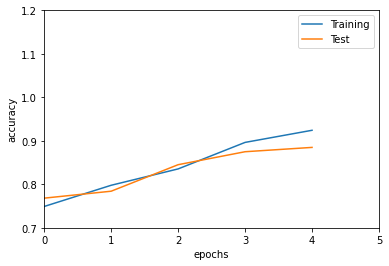

In [28]:
#plot the train and test accuray as a function of epochs
import matplotlib.pyplot as plt
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['Training','Test'], loc='upper right')
plt.xlim([0,5])
plt.ylim([0.7,1.2])

In [29]:
#Evaluating the model with test data
model.evaluate(X_test, y_test)

120/120 [==============================] - 3s 25ms/step - loss: 0.2828 - accuracy: 0.8849


[0.2828049063682556, 0.8848770260810852]

In [ ]:
The accuracy of the model is 88.48%